In [8]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

from jax.nn import softmax
from jax.config import config
from pathlib import Path
from collections import namedtuple

config.update('jax_platform_name', 'cpu')
np.set_printoptions(precision=4)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({'font.size': 18})

from grl.utils import load_info
from definitions import ROOT_DIR

In [21]:
results_dir = Path(ROOT_DIR, 'results', 'baselines')
results_to_graph = ['cheese_lstm']
pomdp_files_dir = Path(ROOT_DIR, 'grl', 'environment', 'pomdp_files')

args_to_keep = ['spec', 'hidden_size', 'seed']
split_by = [arg for arg in args_to_keep if arg != 'seed']

In [22]:
# spec_plot_order = [
#     'example_7', 'tmaze_5_two_thirds_up', 'tiger-alt-start', 'paint.95', 'cheese.95', 'network',
#     'shuttle.95', '4x3.95', 'hallway'
# ]
spec_plot_order = ['cheese.95']
spec_to_belief_state = {'tmaze_5_two_thirds_up': 'tmaze5'}
compare_to = 'belief'


In [23]:
compare_to_list = []
for spec in spec_plot_order:
    for fname in pomdp_files_dir.iterdir():
        if 'pomdp-solver-results' in fname.stem:
            if (fname.stem ==
                    f"{spec_to_belief_state.get(spec, spec)}-pomdp-solver-results"
                ):
                belief_info = load_info(fname)
                coeffs = belief_info['coeffs']
                max_start_vals = coeffs[belief_info['max_start_idx']]
                spec_compare_indv = {
                    'spec': spec,
                    'compare_perf': np.dot(max_start_vals, belief_info['p0'])
                }
                compare_to_list.append(spec_compare_indv)
                break

compare_to_df = pd.DataFrame(compare_to_list)

In [24]:
all_results = []

for agent in results_to_graph:
    agent_res_path = results_dir / agent
    
    for results_path in agent_res_path.iterdir():
        if results_path.is_dir() or results_path.suffix != '.npy':
            continue
        print(results_path)
        info = load_info(results_path)
        print(info)

        args = info['args']

        # agent = info['agent']
        init_reward = info['logs']['avg_reward'][0]
        final_reward = info['logs']['avg_reward'][-1]
        #final_mem_info = info['logs']['greedy_final_mem_stats']

        single_res = {k: args[k] for k in args_to_keep}

        single_res.update({
            'init_reward': init_reward,
            'final_reward': final_reward
            # 'init_policy_perf': get_perf(init_policy_info),
            # 'init_improvement_perf': get_perf(init_improvement_info),
            # 'final_mem_perf': get_perf(final_mem_info),
            # 'init_policy': info['logs']['initial_policy'],
            # 'init_improvement_policy': info['logs']['initial_improvement_policy'],
            # 'final_mem': np.array(agent.memory),
            # 'final_policy': np.array(agent.policy)
        })
        all_results.append(single_res)


all_res_df = pd.DataFrame(all_results)


/Users/Nick/Desktop/CS_Master/GRL/taodav/grl/results/baselines/cheese_lstm/cheese.95_seed(2020)_time(20230503-150235)_20ddd75bfc18cd5eaeb894c7ca5b3e37.npy
{'logs': {'final_pct_success': 0.832, 'avg_len': [54.0, 20.294, 19.918, 20.21, 19.581, 20.15, 20.329, 21.148, 20.691, 19.281, 20.314, 20.207, 19.838, 19.916, 20.084, 20.041, 19.692, 21.622, 20.316, 19.98, 21.331, 18.999, 20.27, 18.739, 20.562, 20.667, 19.73, 19.391, 19.759, 20.371, 20.197, 20.106, 20.469, 19.798, 20.505, 19.542, 21.016, 19.606, 19.586, 20.292, 20.953, 19.08, 19.76, 20.421, 20.326, 19.891, 20.869, 20.001, 19.617, 19.723, 20.478, 20.255, 20.586, 18.663, 19.526, 19.413, 19.943, 19.851, 21.487, 19.727, 19.319, 20.493, 20.243, 20.17, 19.916, 19.422, 20.077, 20.64, 19.763, 20.284, 20.337, 19.404, 19.18, 18.754, 20.756, 19.986, 19.555, 19.562, 20.177, 19.788, 19.199, 20.374, 21.07, 19.893, 20.185, 20.394, 19.768, 20.686, 19.064, 19.889, 20.085, 19.567, 20.99, 19.97, 20.325, 20.49, 20.455, 20.955, 20.385, 19.499, 20.676, 20.

In [25]:
cols_to_normalize = ['init_reward', 'final_reward']
merged_df = all_res_df.merge(compare_to_df, on='spec')

# for col_name in cols_to_normalize:

normalized_df = merged_df.copy()
# normalized_df['init_improvement_perf'] = (normalized_df['init_improvement_perf'] - merged_df['init_policy_perf']) / (merged_df['compare_perf'] - merged_df['init_policy_perf'])
# normalized_df['final_mem_perf'] = (normalized_df['final_mem_perf'] - merged_df['init_policy_perf']) / (merged_df['compare_perf'] - merged_df['init_policy_perf'])
# del normalized_df['init_policy_perf']
del normalized_df['compare_perf']


# all_normalized_perf_results = {}
# for hparams, res in all_results.items():
#     max_key = 'compare_perf'
#     # if max_key not in res:
#     #     max_key = 'final_mem_perf'
#     max_v = res[max_key]
#     min_v = res['init_policy_perf']
#     for k, v in res.items():
#         if '_perf' in k:
#             all_results[hparams][k] = (v - min_v) / (max_v - min_v)
# %%
normalized_df.groupby(split_by).mean()
print(normalized_df)

        spec  hidden_size  seed  init_reward  final_reward
0  cheese.95           12  2020          0.0      0.142213


        spec  hidden_size    seed  init_reward  final_reward
0  cheese.95           12  2020.0          0.0      0.142213
        spec  hidden_size  seed  init_reward  final_reward
0  cheese.95           12   0.0          0.0           0.0
0    0.0
Name: final_reward, dtype: float64


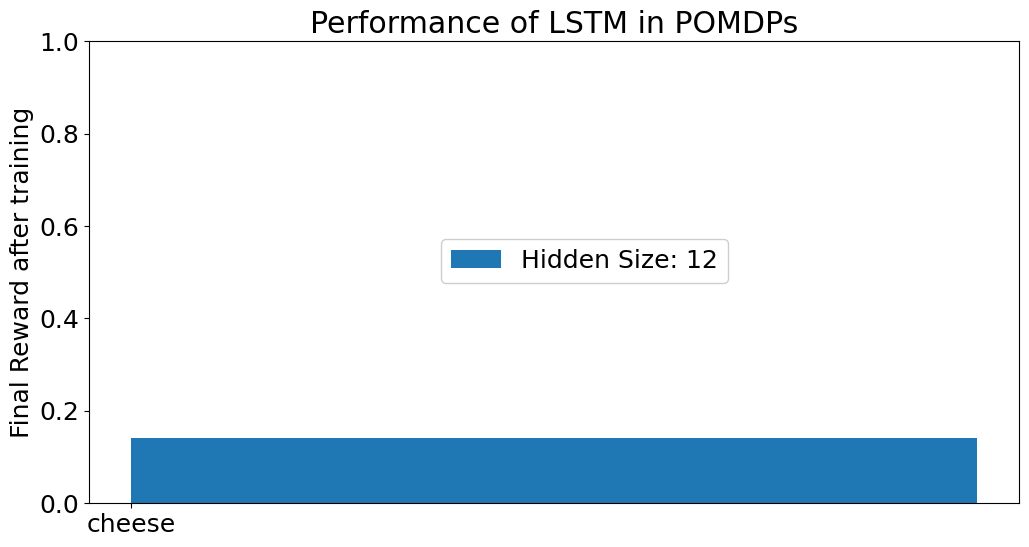

In [36]:
def maybe_spec_map(id: str):
    spec_map = {
        '4x3.95': '4x3',
        'cheese.95': 'cheese',
        'paint.95': 'paint',
        'shuttle.95': 'shuttle',
        'example_7': 'ex. 7',
        'tmaze_5_two_thirds_up': 'tmaze',
        'tiger-alt-start': 'tiger'
    }
    if id not in spec_map:
        return id
    return spec_map[id]

groups = normalized_df.groupby(split_by, as_index=False)
means = groups.mean()
std_errs = groups.std().fillna(0)
num_n_hidden = list(sorted(normalized_df['hidden_size'].unique()))

group_width = 1
bar_width = group_width / (len(num_n_hidden) + 2)
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(means))
xlabels = [maybe_spec_map(l) for l in list(means['spec'])]

for i, n_hidden in enumerate(num_n_hidden):
    ax.bar(x + (i + 2) * bar_width,
           means[means['hidden_size'] == n_hidden]['final_reward'],
           bar_width,
           yerr=std_errs[std_errs['hidden_size'] == n_hidden]['final_reward'],
           label=f"Hidden Size: {int(n_hidden)}")
ax.set_ylim([0, 1])
ax.set_ylabel(f'Final Reward after training')
ax.set_xticks(x + group_width / 2)
ax.set_xticklabels(xlabels)
ax.legend(bbox_to_anchor=(0.7, 0.6), framealpha=0.95)
ax.set_title("Performance of LSTM in POMDPs")

downloads = Path().home() / 'Downloads'
fig_path = downloads / f"{results_dir.stem}.pdf"
fig.savefig(fig_path)
